# レスラー方程式(外力のある状態)

レスラー方程式の外力のある場合に関して，$sin$波に位相のシフトがある場合を考える．

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 3.1 µs


In [2]:
def phase_shift(t):
    # 2πは1日に対応します。8時間は(8/24)*2πに対応します。
    shift_value = (8/24)*2*np.pi
    # 4日ごとに位相をシフトします。
    number_of_shifts = int(t / (4*2*np.pi))
    return number_of_shifts * shift_value


In [3]:
def rossler_system_with_shifted_force(t, state, a, b, c, A):
    x, y, z = state
    dxdt = -y - z + A * np.sin(t + phase_shift(t))  # X項に外力P(t)を加える（位相シフト付き）
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]


In [4]:
# 外力P(t)の振幅Aをパラメータとして追加します。
A = 1.0  # 外力の振幅を設定します。この値を変更することで、外力の強さを変えられます。

# パラメータ
a = 0.2
b = 0.2
c = 5.7

# 初期条件
initial_state = [1.0, 1.0, 1.0]

# 時間の設定
t_span = [0, 2510]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 25100)  # 評価する時間点


In [5]:
# 微分方程式の数値解を求める
solution_with_shifted_force = solve_ivp(
    rossler_system_with_shifted_force, t_span, initial_state,
    args=(a, b, c, A), t_eval=t_eval, max_step=0.01
)

# 外力P(t)の計算（位相シフト付き）
P_shifted = A * np.sin(solution_with_shifted_force.t + np.array([phase_shift(ti) for ti in solution_with_shifted_force.t]))

# DataFrameの作成
data_frame_with_shifted_force = pd.DataFrame({
    'time': solution_with_shifted_force.t,
    'x': solution_with_shifted_force.y[0],
    'y': solution_with_shifted_force.y[1],
    'z': solution_with_shifted_force.y[2],
    'P_shifted': P_shifted  # 位相シフトされた外力P(t)の列を追加
})


In [6]:
filename_with_force = f"rossler_data_with_shifted_forceA{A}.csv"

# CSVファイルにデータを保存
data_frame_with_shifted_force.to_csv(filename_with_force, index=False)


# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values



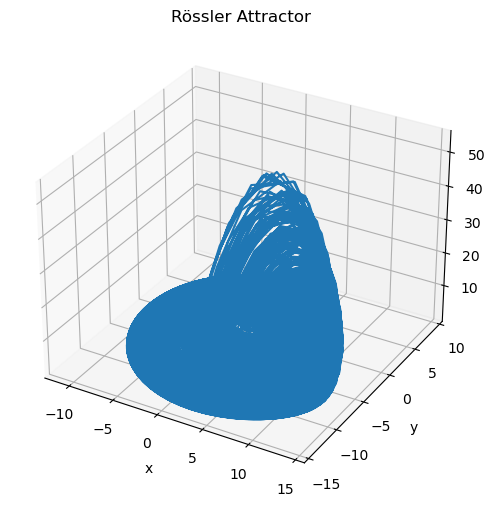

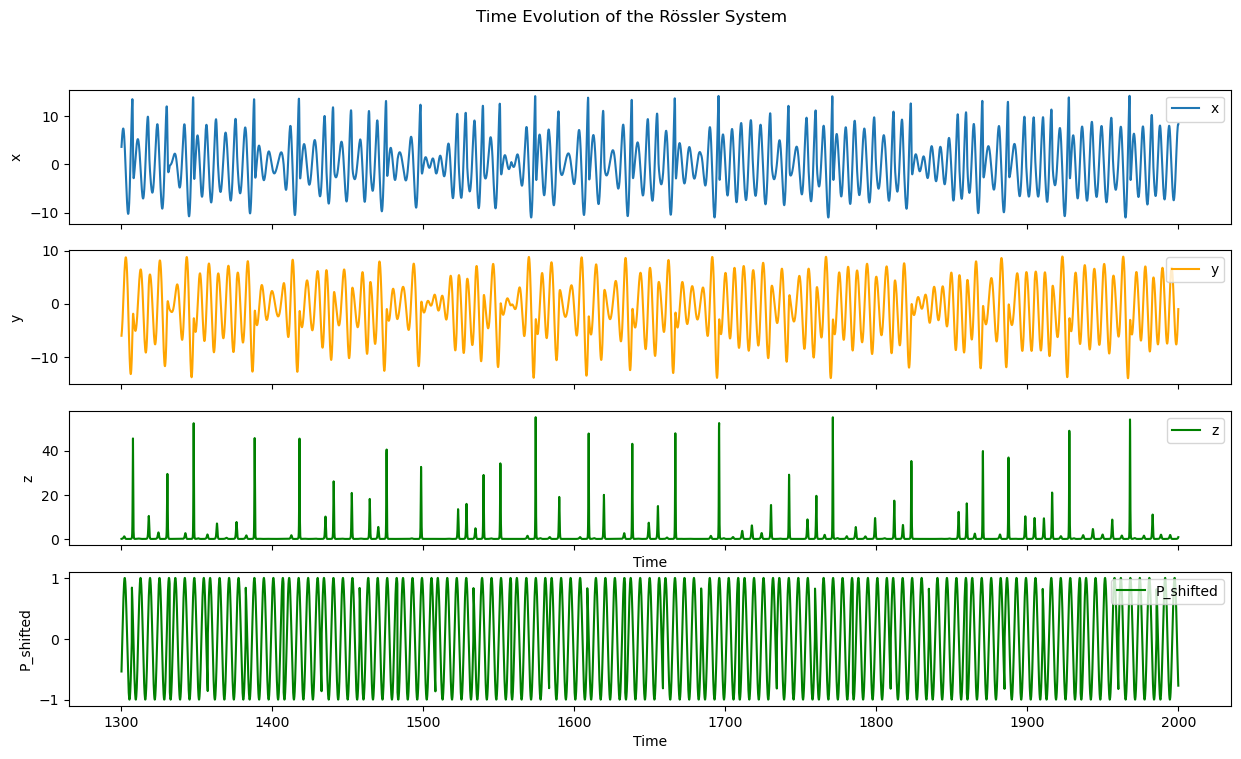

In [7]:
# XYZの三次元グラフをプロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_frame_with_shifted_force['x'], data_frame_with_shifted_force['y'], data_frame_with_shifted_force['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rössler Attractor')
plt.show()

sample = 13000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['x'][sample: sample+7000], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['y'][sample: sample+7000], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

axs[2].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['z'][sample: sample+7000], label='z', color='green')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Time')
axs[2].legend(loc='upper right')

axs[3].plot(data_frame_with_shifted_force['time'][sample: sample+7000], data_frame_with_shifted_force['P_shifted'][sample: sample+7000], label='P_shifted', color='green')
axs[3].set_ylabel('P_shifted')
axs[3].set_xlabel('Time')
axs[3].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()


ここまで，正しくシミュレーションが出来た．

実際にESNを用いる際に扱うデータはXであるが，これはレスラー方程式のx, y項のみを含む二次元の配列である．

In [8]:
X.shape


(25100, 3)